In [15]:

import pandas as pd
import numpy as np
import os
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [16]:
data_dict = {}
for files in os.listdir(data_folder):
    try:
        data_dict[files.replace('.csv','')] = pd.read_csv(data_folder+files)
    except:
        data_dict[files.replace('.csv','')] = pd.read_csv(data_folder+files, sep='::', engine='python', encoding='latin-1')

In [17]:
data_dict.keys()

dict_keys(['users', 'test', 'SampleSubmisson', 'train', 'movies'])

In [18]:
#dict_keys(['users', 'test', 'SampleSubmisson', 'train', 'movies'])
users = data_dict['users'].copy()
movies = data_dict['movies'].copy()
train = data_dict['train'].copy()
test = data_dict['test'].copy()
sample_submission = data_dict['SampleSubmisson'].copy()

Cleaning Movies Data

In [19]:
movies.head()

,movieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [20]:
movies = data_dict['movies']
movies['Genres'].unique()
# split genres
movies['Genres_'] = movies['Genres'].str.split('|')
# get unique genres
genres = set()
for i in movies['Genres_']:
    genres.update(i)
for i in genres:
    # create a new column for each genre 1 and 0
    movies[i] = movies['Genres_'].apply(lambda x: 1 if i in x else 0)
movies = movies.drop(columns=['Genres_','Genres','Title'])
movies = movies.rename(columns={'movieID':'MovieID'})
movies

,MovieID,Fantasy,Horror,Romance,Sci-Fi,War,Mystery,Film-Noir,Animation,Adventure,Comedy,Children's,Action,Documentary,Thriller,Crime,Western,Musical,Drama
0,1,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0
1,2,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
2,3,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
4,5,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,3948,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3879,3949,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3880,3950,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3881,3951,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [21]:
users['is_male'] = np.where(users['Gender'] == 'M', 1, 0)
#drop gender column
users = users.drop(columns=['Gender','Zip-code'])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


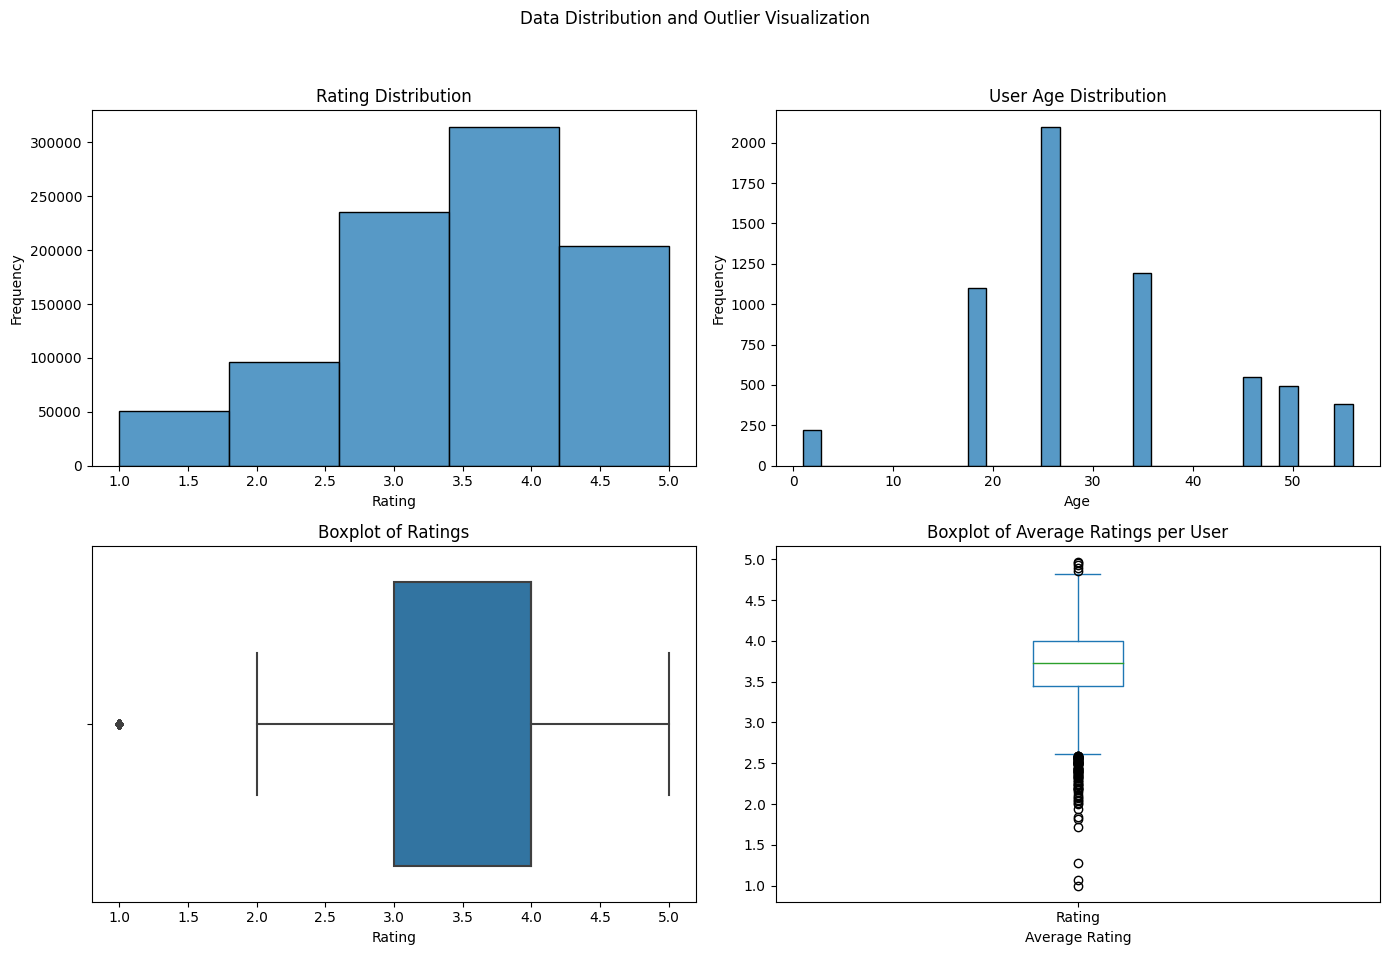

{'Train Data Missing': TrainDataID    0
 UserID         0
 MovieID        0
 Rating         0
 dtype: int64,
 'Test Data Missing': TestDataID    0
 UserID        0
 MovieID       0
 dtype: int64,
 'Users Data Missing': UserID        0
 Age           0
 Occupation    0
 is_male       0
 dtype: int64,
 'Movies Data Missing': MovieID        0
 Fantasy        0
 Horror         0
 Romance        0
 Sci-Fi         0
 War            0
 Mystery        0
 Film-Noir      0
 Animation      0
 Adventure      0
 Comedy         0
 Children's     0
 Action         0
 Documentary    0
 Thriller       0
 Crime          0
 Western        0
 Musical        0
 Drama          0
 dtype: int64}

In [22]:


# Set up the visualization layout
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
fig.suptitle('Data Distribution and Outlier Visualization')

# Plot for distribution of ratings in train data
sns.histplot(train['Rating'], bins=5, kde=False, ax=axes[0, 0])
axes[0, 0].set_title('Rating Distribution')
axes[0, 0].set_xlabel('Rating')
axes[0, 0].set_ylabel('Frequency')

# Plot for distribution of user ages
sns.histplot(users['Age'], bins=30, kde=False, ax=axes[0, 1])
axes[0, 1].set_title('User Age Distribution')
axes[0, 1].set_xlabel('Age')
axes[0, 1].set_ylabel('Frequency')

# Boxplot for ratings per movie
sns.boxplot(x=train['Rating'], ax=axes[1, 0])
axes[1, 0].set_title('Boxplot of Ratings')
axes[1, 0].set_xlabel('Rating')

# Boxplot for ratings per user
train.groupby('UserID').mean()['Rating'].plot(kind='box', ax=axes[1, 1])
axes[1, 1].set_title('Boxplot of Average Ratings per User')
axes[1, 1].set_xlabel('Average Rating')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Check for missing data in all datasets
missing_data = {
    "Train Data Missing": train.isnull().sum(),
    "Test Data Missing": test.isnull().sum(),
    "Users Data Missing": users.isnull().sum(),
    "Movies Data Missing": movies.isnull().sum()
}

missing_data


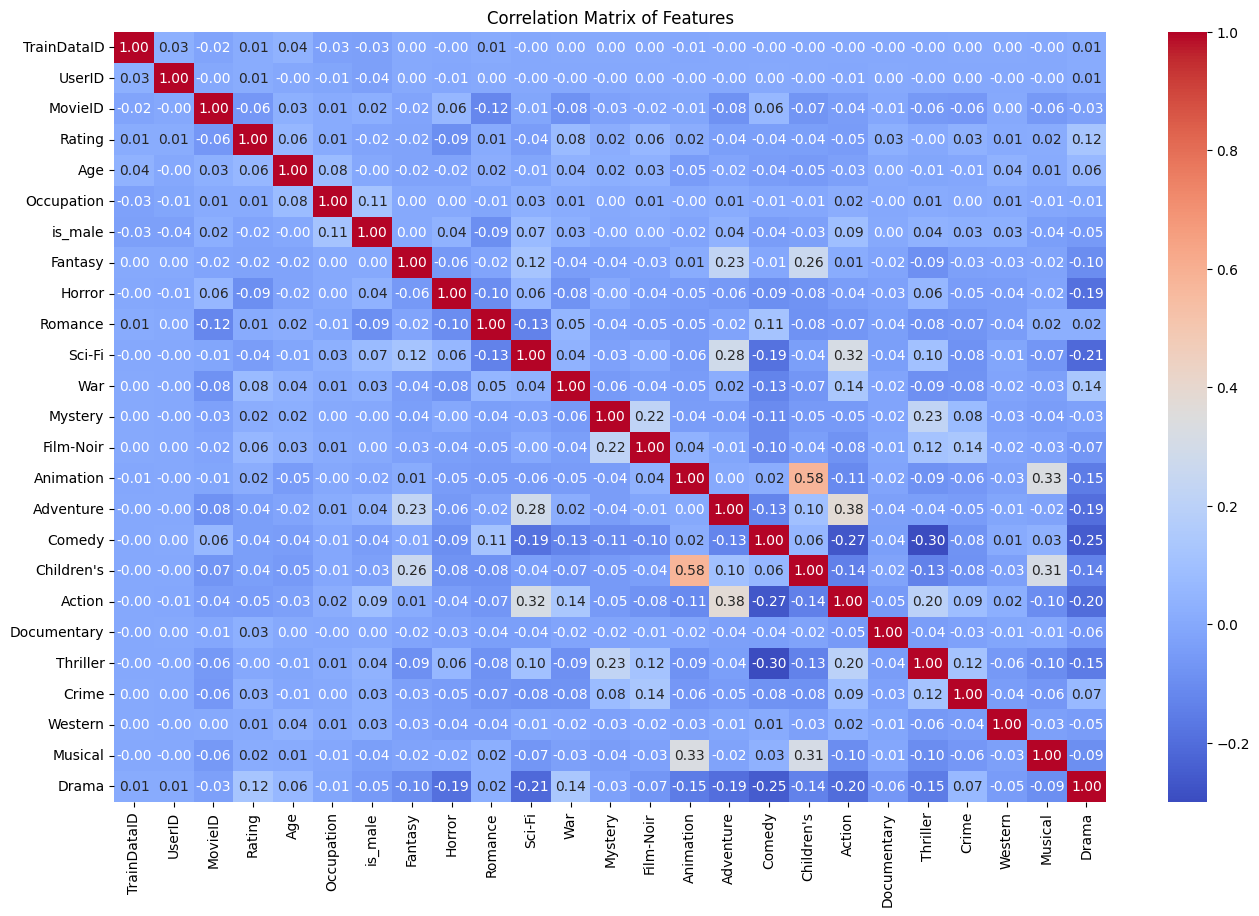

In [23]:

# Merging train dataset with users and movies to include user demographics and movie genres
train_merged = pd.merge(train, users, on='UserID')
train_merged = pd.merge(train_merged, movies, on='MovieID', how='left')

# Calculate correlation matrix
correlation_matrix = train_merged.corr()

# Heatmap to visualize the correlations
plt.figure(figsize=(16, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Matrix of Features')
plt.show()


In [24]:
# Calculate overall mean rating
overall_mean_rating = train['Rating'].mean()

# Calculate User Bias
user_bias = train.groupby('UserID')['Rating'].mean() - overall_mean_rating
user_bias = user_bias.reset_index().rename(columns={'Rating': 'UserBias'})

# Calculate Movie Popularity
movie_popularity = train.groupby('MovieID')['Rating'].count()
movie_popularity = movie_popularity.reset_index().rename(columns={'Rating': 'MoviePopularity'})

# Calculate User Activity Level
user_activity = train.groupby('UserID')['Rating'].count()
user_activity = user_activity.reset_index().rename(columns={'Rating': 'UserActivity'})

# Merge these new features back to the train dataset
train_enhanced = pd.merge(train, user_bias, on='UserID')
train_enhanced = pd.merge(train_enhanced, movie_popularity, on='MovieID')
train_enhanced = pd.merge(train_enhanced, user_activity, on='UserID')

# Display the enhanced train dataset with new features
train_enhanced.head(5) , train_enhanced.tail(5)


(   TrainDataID  UserID  MovieID  Rating  UserBias  MoviePopularity  \
 0            1     796     1193       5  0.598288             1535   
 1            2     796      661       3  0.598288              466   
 2            3     796      914       3  0.598288              579   
 3            4     796     3408       4  0.598288             1170   
 4            5     796     2355       5  0.598288             1524   
 
    UserActivity  
 0            50  
 1            50  
 2            50  
 3            50  
 4            50  ,
         TrainDataID  UserID  MovieID  Rating  UserBias  MoviePopularity  \
 899868       899869    2683     1090       3 -0.022502             1034   
 899869       899870    2683     1091       1 -0.022502              340   
 899870       899871    2683     1094       5 -0.022502             1117   
 899871       899872    2683      562       5 -0.022502              433   
 899872       899873    2683     1097       4 -0.022502             2020   
 

In [25]:


# Create a sparse matrix
pivot_matrix = train_enhanced.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0)
sparse_matrix = csr_matrix(pivot_matrix.values)

#build a df for n_components and rmse, to find the best n_components
rmse_df = pd.DataFrame(columns=['n_components', 'rmse'])
for n in range(1, 31):
    svd = TruncatedSVD(n_components=n, random_state=42)
    user_features = svd.fit_transform(sparse_matrix)
    predicted_ratings = user_features.dot(svd.components_)
    predicted_ratings = pd.DataFrame(predicted_ratings, columns=pivot_matrix.columns, index=pivot_matrix.index)
    rmse = sqrt(mean_squared_error(predicted_ratings.values, pivot_matrix.values))
    rmse_df = pd.concat([rmse_df, pd.DataFrame({'n_components': [n], 'rmse': [rmse]})])


/var/folders/0b/ck588rqj4fb605kb4f66vr9r0000gn/T/ipykernel_81640/2125701863.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rmse_df = pd.concat([rmse_df, pd.DataFrame({'n_components': [n], 'rmse': [rmse]})])


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


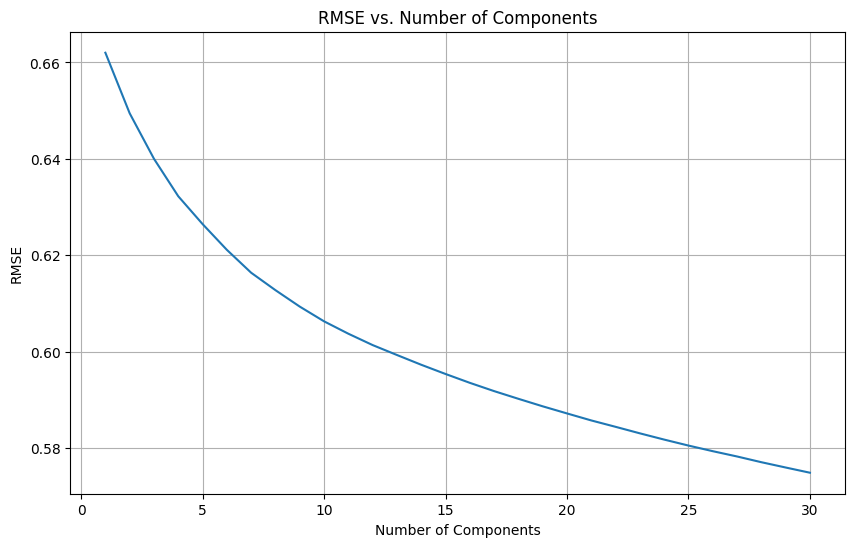

In [26]:
#plot the rmse
plt.figure(figsize=(10, 6))
sns.lineplot(x='n_components', y='rmse', data=rmse_df)
plt.title('RMSE vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('RMSE')
plt.grid()
plt.show()


In [29]:
#build back the train_df using X_train and y_train
train_df = pd.concat([X_train, y_train], axis=1)

In [51]:
# Create user-movie matrix
pivot_matrix = train_df.pivot_table(index='UserID', columns='MovieID', values='Rating').fillna(0)
sparse_matrix = csr_matrix(pivot_matrix.values)
rmse_df_hybrid = pd.DataFrame(columns=['n_components', 'rmse'])
for n in range(1, 31):
    svd = TruncatedSVD(n_components=n, random_state=42)
    user_features = svd.fit_transform(sparse_matrix)
    user_features_df = pd.DataFrame(user_features, index=pivot_matrix.index)
    user_features_df = user_features_df.reset_index()
    
    # Merge SVD features with original training data
    merged_data = pd.merge(train_df, user_features_df, on='UserID')
    #rename the columns name to string if it is a number
    merged_data.columns = [str(i) for i in merged_data.columns]
    
    # Prepare features and target for regression
    X = merged_data.drop(['TrainDataID', , 'MovieID', 'Rating'], axis=1)
    y = merged_data['Rating']
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Linear Regression Model
    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    print(f'n = {n}, RMSE: {rmse}')
    rmse_df_hybrid = pd.concat([rmse_df_hybrid, pd.DataFrame({'n_components': [n], 'rmse': [rmse]})])



n = 1, RMSE: 0.9982941353589208


/var/folders/0b/ck588rqj4fb605kb4f66vr9r0000gn/T/ipykernel_81640/1781647372.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rmse_df_hybrid = pd.concat([rmse_df_hybrid, pd.DataFrame({'n_components': [n], 'rmse': [rmse]})])


n = 2, RMSE: 0.9982808254700218
n = 3, RMSE: 0.9982690327014111
n = 4, RMSE: 0.9981802172315059
n = 5, RMSE: 0.9981657623987547
n = 6, RMSE: 0.9981126838335939
n = 7, RMSE: 0.9979904600367682
n = 8, RMSE: 0.9979954465247552
n = 9, RMSE: 0.9979915842632069
n = 10, RMSE: 0.9979902845226772
n = 11, RMSE: 0.9979904976799818
n = 12, RMSE: 0.9979812291079343
n = 13, RMSE: 0.9979786026151317
n = 14, RMSE: 0.9979800668056068
n = 15, RMSE: 0.9979757381691388
n = 16, RMSE: 0.9979776337485852
n = 17, RMSE: 0.9979704359090752
n = 18, RMSE: 0.9979630060540369
n = 19, RMSE: 0.9979751219781146
n = 20, RMSE: 0.9979553037923452
n = 21, RMSE: 0.9979581590330489
n = 22, RMSE: 0.9979630796029506
n = 23, RMSE: 0.9979482448084362
n = 24, RMSE: 0.9979612901781116
n = 25, RMSE: 0.9979527855735207
n = 26, RMSE: 0.9979587850007839
n = 27, RMSE: 0.9979494214104317
n = 28, RMSE: 0.9979422654590943
n = 29, RMSE: 0.9979612465146437
n = 30, RMSE: 0.9979468197522849


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


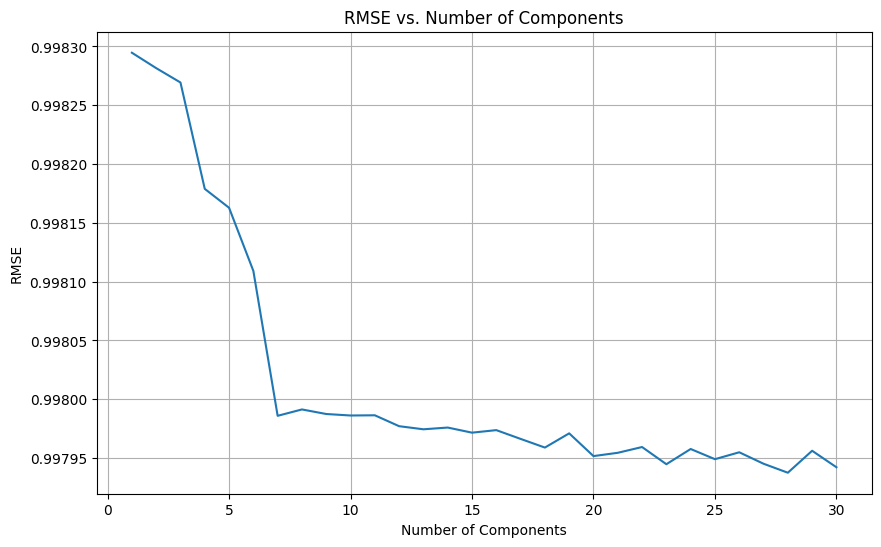

In [43]:
#plot the rmse
plt.figure(figsize=(10, 6))
sns.lineplot(x='n_components', y='rmse', data=rmse_df_hybrid)
plt.title('RMSE vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('RMSE')
plt.grid()
plt.show()

In [50]:
# Create user-movie matrix
pivot_matrix = train_df.pivot_table(index='UserID', columns='MovieID', values='Rating').fillna(0)
sparse_matrix = csr_matrix(pivot_matrix.values)
rmse_df_hybrid = pd.DataFrame(columns=['n_components', 'rmse'])
for n in range(1, 31):
    svd = TruncatedSVD(n_components=n, random_state=42)
    user_features = svd.fit_transform(sparse_matrix)
    user_features_df = pd.DataFrame(user_features, index=pivot_matrix.index)
    user_features_df = user_features_df.reset_index()
    
    # Merge SVD features with original training data
    merged_data = pd.merge(train_df, user_features_df, on='UserID')
    #rename the columns name to string if it is a number
    merged_data.columns = [str(i) for i in merged_data.columns]
    
    # Prepare features and target for regression
    X = merged_data.drop(['TrainDataID', 'UserID', 'MovieID', 'Rating','MoviePopularity','UserBias','UserActivity'], axis=1)
    y = merged_data['Rating']
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Linear Regression Model
    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    print(f'n = {n}, RMSE: {rmse}')
    rmse_df_hybrid = pd.concat([rmse_df_hybrid, pd.DataFrame({'n_components': [n], 'rmse': [rmse]})])



n = 1, RMSE: 1.112846601952867


/var/folders/0b/ck588rqj4fb605kb4f66vr9r0000gn/T/ipykernel_81640/1962318369.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rmse_df_hybrid = pd.concat([rmse_df_hybrid, pd.DataFrame({'n_components': [n], 'rmse': [rmse]})])


n = 2, RMSE: 1.110351246355201
n = 3, RMSE: 1.1102211386696228
n = 4, RMSE: 1.1094484293161773
n = 5, RMSE: 1.1083038853364826
n = 6, RMSE: 1.1073781234326778
n = 7, RMSE: 1.1073138815229175
n = 8, RMSE: 1.1068733269280027
n = 9, RMSE: 1.1066989322143903
n = 10, RMSE: 1.1066932915691603
n = 11, RMSE: 1.106475942716034
n = 12, RMSE: 1.1063787829668332
n = 13, RMSE: 1.1063966033940624
n = 14, RMSE: 1.106289874257312
n = 15, RMSE: 1.1062374174795528
n = 16, RMSE: 1.1060300233243223
n = 17, RMSE: 1.1059001804887278
n = 18, RMSE: 1.1056998517780239
n = 19, RMSE: 1.1056182033322748
n = 20, RMSE: 1.1057340724764602
n = 21, RMSE: 1.1056908220833492
n = 22, RMSE: 1.1055443506734317
n = 23, RMSE: 1.1053653107040864
n = 24, RMSE: 1.1055268906249394
n = 25, RMSE: 1.10516215298021
n = 26, RMSE: 1.1048998557159189
n = 27, RMSE: 1.1052861972863632
n = 28, RMSE: 1.1050493981244576
n = 29, RMSE: 1.1049835366688117
n = 30, RMSE: 1.1046658382360184


In [44]:
train_df

,TrainDataID,UserID,MovieID,UserBias,MoviePopularity,UserActivity,Rating
4380,4381,291,2239,-0.026157,87,189,4
381297,381298,2651,1580,-0.213291,2253,38,3
739773,739774,1778,1947,0.210323,689,226,5
785242,785243,2159,2125,0.050142,375,383,3
199178,199179,4591,3190,-1.437252,142,713,1
...,...,...,...,...,...,...,...
259178,259179,2736,2338,0.688129,268,189,5
365838,365839,5827,1992,-0.251925,125,94,1
131932,131933,2425,1101,-0.405241,919,17,2
671155,671156,2715,2841,0.100106,434,176,3


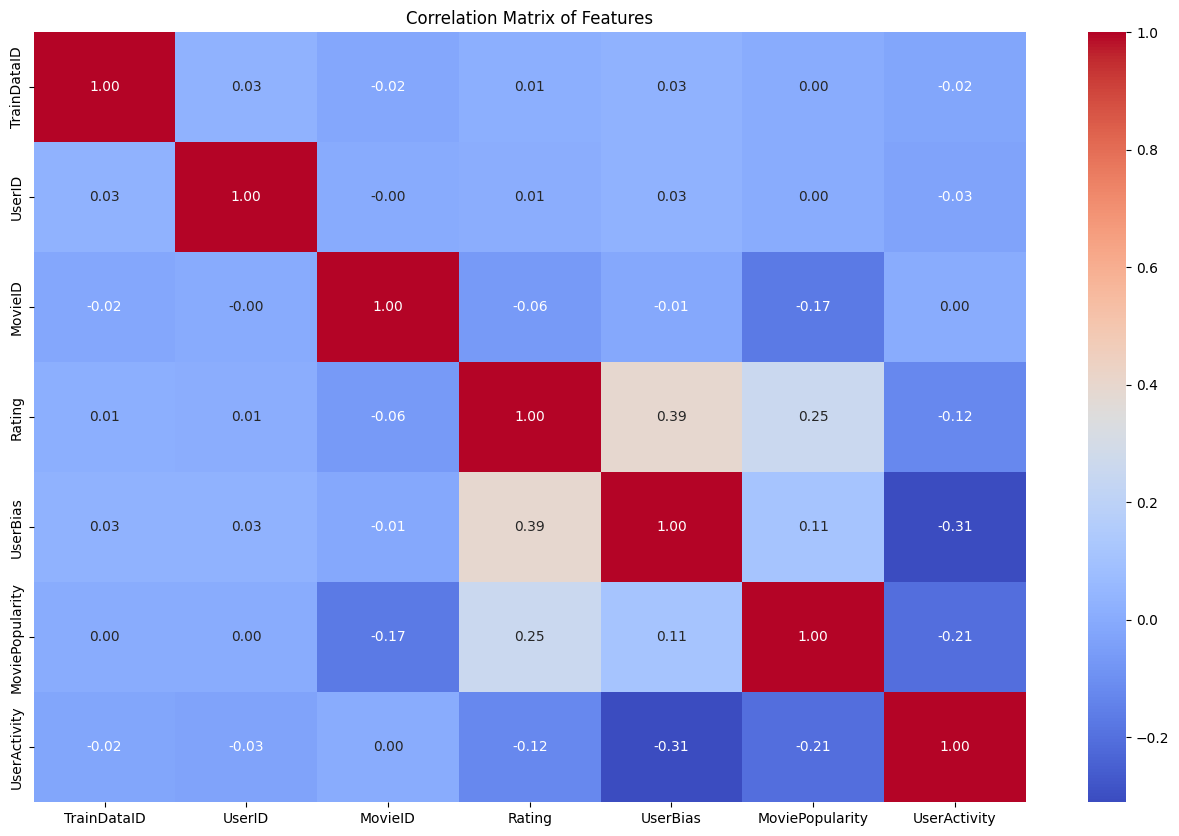

In [46]:

correlation_matrix = train_enhanced.corr()

# Heatmap to visualize the correlations
plt.figure(figsize=(16, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Matrix of Features')
plt.show()


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,14.400529,11.278520,0.558231,2.162657,-4.478746,-5.374984,4.207170,0.830725,0.919646,-0.138514,...,-2.889900,1.700421,-1.118777,5.167298,2.867950,-3.989990,1.447406,-1.336706,-0.679055,-2.296146
1,3.583184,0.382287,-0.225900,-0.973339,-0.797855,0.497397,0.311563,0.551832,-0.400702,-0.816157,...,-0.114945,-1.209430,0.477918,-1.276953,0.597941,0.622999,-1.889904,-2.117726,-1.835113,1.042990
2,17.453352,14.816474,3.681876,1.245035,-5.127944,1.922307,7.456396,-0.516784,3.387332,1.744771,...,-0.807911,-3.109070,0.896355,1.865738,1.410692,-0.391002,1.401196,-1.110610,1.766718,-1.700816
3,32.528770,9.196053,-5.543131,-3.063274,2.988423,-4.071586,0.243379,-7.389539,5.454882,0.541933,...,-4.321015,-5.605947,3.207918,0.894205,-1.726411,-0.857630,-4.046714,2.453418,-1.116775,1.540005
4,35.454576,-2.948706,5.820184,0.035346,6.202586,-1.757402,-1.214360,-1.528657,-3.042518,4.511478,...,-1.854427,-1.530459,-1.169875,-6.843410,-0.923384,2.303707,-0.382059,-2.711076,-1.939875,-0.889184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
719893,12.189276,-1.802866,12.434595,-1.782479,4.230243,12.853741,4.308003,0.012825,-10.071566,-6.190298,...,1.733070,-1.122648,2.041163,-0.596845,3.380867,0.959411,2.339290,-0.633145,3.412954,1.275958
719894,5.959577,-1.750718,1.337878,3.083774,-3.230136,1.289968,3.731833,2.354656,-7.149403,5.105778,...,-1.653642,-0.767440,-2.968240,-2.334738,-1.103580,1.155840,-0.314040,-2.140545,1.667153,0.113600
719895,1.619460,0.355452,-0.176658,0.849491,-1.082187,-0.041608,-1.465990,-0.963553,0.513957,-0.637790,...,-0.110143,0.844735,-0.556900,-0.317802,0.299733,0.070577,0.118128,0.039626,-0.582581,0.773782
719896,17.084108,-2.720357,-14.150510,-7.405198,1.510925,-0.426933,3.217480,-3.574347,0.256030,1.562175,...,1.279235,-2.404900,-0.249927,2.240594,0.319945,1.164542,-2.094172,-0.292148,-0.196809,-2.890156
